In [1]:
library(repr)
library(dplyr)
library(tidyverse)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [2]:
# Downloading the unscaled dataset from the web.
pulsar_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(pulsar_url, "HTRU2.zip")
unzip("HTRU2.zip")

# Reading and tidying the dataset.
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |> 
    # Add column names:
    rename(mean_intp = X1, 
           std_dev_intp = X2, 
           xs_kurtosis_intp = X3, 
           skewness_intp = X4, 
           mean_dmsnr = X5, 
           std_dev_dmsnr = X6, 
           xs_kurtosis_dmsnr = X7, 
           skewness_dmsnr = X8, 
           class = X9) |>
    tibble::rowid_to_column('id') |> # Adds an id to each individual pulsar star candidate.
    mutate(class = as_factor(class), id = as_factor(id)) |> # Change class from dbl to factor (category) as these are categorial variables.
    select(id, class, everything()) |> # Reorder class as the first column in the table for organization purposes.
    mutate(class = case_when(class == 0 ~ "non_pulsar",
                            class == 1 ~ "pulsar")) # Clarify the classes.



Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Split data into training and testing data

pulsar_data_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_data_train <- training(pulsar_data_split)
pulsar_data_testing <- testing(pulsar_data_split)

# Balancing the classes

ups_recipe <- recipe(class ~ ., data = pulsar_data_train) |>
              step_upsample(class, over_ratio = 1, skip = FALSE) |>
              prep()

pulsar_data_training <- bake(ups_recipe, pulsar_data_train)

In [4]:
# Create recipe with training data that centres and scales data

pulsar_data_recipe <- recipe(class ~ mean_intp + std_dev_intp + xs_kurtosis_intp + skewness_intp + mean_dmsnr + std_dev_dmsnr +
                                     xs_kurtosis_dmsnr + skewness_dmsnr, data = pulsar_data_training) |>
                      step_scale(all_predictors()) |>
                      step_center(all_predictors())


In [5]:
# Create KNN model that sets neighbours to tune()

pulsar_data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")

In [6]:
# Create cross validation using training data

pulsar_data_vfold <- vfold_cv(pulsar_data_training, v = 5, strata = class)


In [7]:
# Create workflow

grid_vals <- tibble(neighbors = 1:10)

pulsar_data_results <- workflow() |>
                       add_recipe(pulsar_data_recipe) |>
                       add_model(pulsar_data_tune) |>
                       tune_grid(resamples = pulsar_data_vfold, grid = grid_vals) |>
                       collect_metrics()

In [8]:
pulsar_data_accuracy_results <- pulsar_data_results |>
                       filter(.metric == "accuracy") # Filters to only the accuracy metric.

pulsar_data_accuracy_results

pulsar_data_optimal_k <- pulsar_data_accuracy_results |>
                         filter(mean == max(mean)) |>
                         select(neighbors) # Gets the optimal k-value.

pulsar_data_optimal_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9901607,5,0.0008722963,Preprocessor1_Model01
2,accuracy,binary,0.9901607,5,0.0008722963,Preprocessor1_Model02
3,accuracy,binary,0.9833961,5,0.0013554281,Preprocessor1_Model03
4,accuracy,binary,0.9833961,5,0.0013554281,Preprocessor1_Model04
5,accuracy,binary,0.9762626,5,0.0012878670,Preprocessor1_Model05
6,accuracy,binary,0.9762626,5,0.0012878670,Preprocessor1_Model06
7,accuracy,binary,0.9694981,5,0.0010099023,Preprocessor1_Model07
8,accuracy,binary,0.9694981,5,0.0010099023,Preprocessor1_Model08
9,accuracy,binary,0.9624466,5,0.0009067448,Preprocessor1_Model09


neighbors
<int>
1
2


In [9]:
#using optimal K value to create the specification

knn_specification <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |> 
                     set_engine("kknn") |> 
                     set_mode("classification")

#using the same recipe in the workflow and fit into data training

knn_fit <- workflow() |> 
                add_recipe(pulsar_data_recipe) |> 
                add_model(knn_specification) |> 
                fit(data = pulsar_data_training)

#predicting
knn_prediction <- predict(knn_fit, pulsar_data_testing) |> 
                  bind_cols(pulsar_data_testing)

knn_prediction2 <- knn_prediction |>
                   mutate(class = as_factor(class))

knn_metrics <-  knn_prediction2 |> 
                metrics(truth = class, estimate = .pred_class) |>
                filter(.metric == "accuracy")
knn_metrics



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9705028


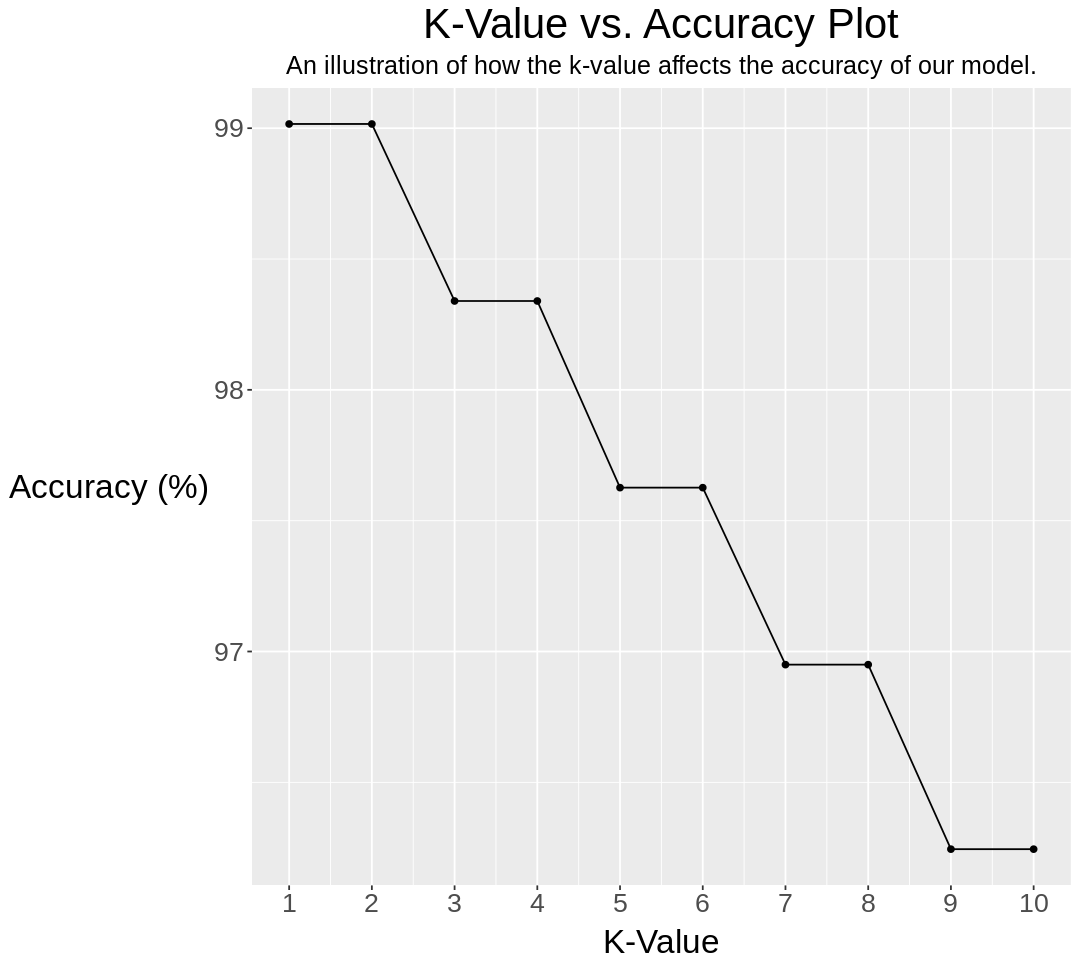

In [10]:
options(repr.plot.width = 9, repr.plot.height = 8) # Resize the plot.

# pulsar_data_results |>
#     filter(.metric == "accuracy") # Uncomment this to show all accuracies in a table.

pulsar_data_results_plot <- pulsar_data_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean) |>
                mutate(mean = mean*100) |> # Converts the accuracy from a decimal to a percentage.
                ggplot(aes(x = neighbors, y = mean)) +
                geom_line() + 
                geom_point() +
                labs(x = "K-Value", 
                     y = "Accuracy (%)", 
                     title = "K-Value vs. Accuracy Plot", 
                     subtitle = "An illustration of how the k-value affects the accuracy of our model.") +
                theme(text = element_text(size=20), 
                      plot.subtitle = element_text(size=15, hjust = 0.5), 
                      plot.title = element_text(size = 25, hjust = 0.5),
                      axis.title.y = element_text(size=20, angle = 0, vjust = 0.5),
                      axis.title.x = element_text(size=20, vjust = -0.25)) + # Makes the text more readable. +
                scale_x_continuous(breaks = 1:10) # Make the x-axis values go from the integers 1-10.

pulsar_data_results_plot

From the plot, we can see that the $k$-values that yield the most accurate results are 1 and 2. In this case, the $k$-value of 1 is the most optimal for our model as it is an odd number thus preventing ties from occuring when comparing the ratio of pulsars and non-pulsars during classification.